# Clustering 

In [1]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

# Project files.
from util import gradient_descent, generate_polynomial_data
import plot_helpers
from regressors import LinearRegressor
from regularizers import Regularizer, L2Regularizer

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
# If in your browser the figures are not nicely vizualized, change the following line. 
pylab.rcParams['figure.figsize'] = (10, 5)

# Machine Learning library. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
# from sklearn import datasets, linear_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_samples = 1500 

def change_k(n_clusters, dataset, algorithm):
    if dataset is 'blobs':
        X, y = datasets.make_blobs(n_samples=n_samples, random_state=8)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=.05)
    elif dataset is 'no_structure':
        X, Y = np.random.rand(n_samples, 2), None 
    elif dataset is 'anisotropic':
        X, Y = datasets.make_blobs(n_samples=n_samples, random_state=170)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X = np.dot(X, transformation)
    elif dataset == 'varied variance':
        X, Y = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)
    elif dataset == 'iris':
        X, y = datasets.load_iris().data, datasets.load_iris().target
    elif dataset == 'MNIST PCA Reduced':
        X, y = datasets.load_digits().data, datasets.load_digits().target
        X = PCA(n_components=2).fit_transform(X)
        
    X = StandardScaler().fit_transform(X)
    
    if algorithm == 'kmeans++':
        algorithm = cluster.KMeans(n_clusters=n_clusters, init='k-means++')
    elif algorithm == 'kmeans':
        algorithm = cluster.KMeans(n_clusters=n_clusters, init='random')
    elif algorithm == 'GMM full':
        # 'full' (each component has its own general covariance matrix)
        algorithm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    elif algorithm == 'GMM tied':
        # 'tied' (all components share the same general covariance matrix),
        algorithm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='tied')
    elif algorithm == 'GMM spherical':
        # 'spherical' (each component has its own single variance).
        algorithm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='spherical')
    elif algorithm == 'GMM diag':
        # 'diag' (each component has its own diagonal covariance matrix),
        algorithm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='diag')
    elif algorithm == 'kmeans RBF kernel':
        algorithm = cluster.SpectralClustering(n_clusters=n_clusters, affinity="rbf")
    elif algorithm == 'kmeans nearest neighbor kernel': 
        algorithm = cluster.SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors")
            
    algorithm.fit(X)
    
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int) 
    else:
        y_pred = algorithm.predict(X)

    colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                       '#f781bf', '#a65628', '#984ea3',
                       '#999999', '#e41a1c', '#dede00', 
                       '#000000'][0:max(y_pred)+1])
    
    ax = plt.subplot(111)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
    
    if hasattr(algorithm, 'covariances_'):
        for n, color in enumerate(colors):
            if algorithm.covariance_type == 'full':
                covariances = algorithm.covariances_[n][:2, :2]
            elif algorithm.covariance_type == 'tied':
                covariances = algorithm.covariances_[:2, :2]
            elif algorithm.covariance_type == 'diag':
                covariances = np.diag(algorithm.covariances_[n][:2])
            elif algorithm.covariance_type == 'spherical':
                covariances = np.eye(algorithm.means_.shape[1]) * algorithm.covariances_[n]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(algorithm.means_[n, :2], v[0], v[1],
                                      180 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

interact(change_k, 
        n_clusters=ipywidgets.IntSlider(value=1, min=1, max=10, step=1),
        dataset=['blobs', 'circles', 'moons', 'no_structure', 'anisotropic', 'varied variance', 'iris', 'MNIST PCA Reduced'],
        algorithm= ['kmeans++', 'kmeans', 'GMM full', 'GMM tied', 'GMM spherical', 'GMM diag', 
                    'kmeans RBF kernel', 'kmeans nearest neighbor kernel']);

interactive(children=(IntSlider(value=1, description='n_clusters', max=10, min=1), Dropdown(description='datas…

# Dimensionality reduction: PCA 

In [3]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn import datasets

def demo_pca(dataset):
    np.random.seed(0)
    n_samples=400
    if dataset is 'blobs':
        X, y = datasets.make_blobs(n_samples=n_samples, random_state=4)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=.05)
    elif dataset is 'no_structure':
        X, Y = np.random.rand(n_samples, 2), None 
    elif dataset is 'anisotropic':
        X, Y = datasets.make_blobs(n_samples=n_samples, random_state=170)
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        X = np.dot(X, transformation)
    elif dataset == 'varied variance':
        X, Y = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)
    elif dataset == 'iris':
        X, y = datasets.load_iris().data, datasets.load_iris().target
    X = X - np.mean(X, axis=0)
    pca = KernelPCA(n_components=1, 
                    kernel="linear", 
                    fit_inverse_transform=True)
    X_pca = pca.fit_transform(X)
    X_back = pca.inverse_transform(X_pca)
    
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], 'bo', label='Original Data');
    plt.plot(X_back[:, 0], X_back[:, 1], 'r*', label='PCA reduced Data');
    plt.legend()

    # print("Total explained variance: {}".format(pca.explained_variance_ratio_[0]))

interact(demo_pca, 
         dataset=['blobs', 'circles', 'moons', 'no_structure', 'anisotropic', 'varied variance', 'iris'],
         # kernel=['linear', 'poly', 'rbf'],
         # n_components=ipywidgets.IntSlider(value=1, min=1, max=2, step=1),
         # gamma = ipywidgets.FloatSlider(value=0, min=-3, max=3, step=0.5)
        );

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'no_structure', 'a…

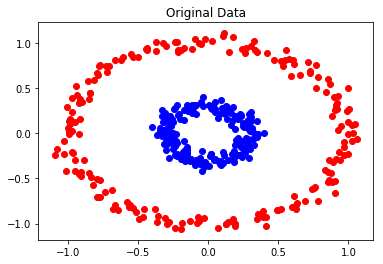

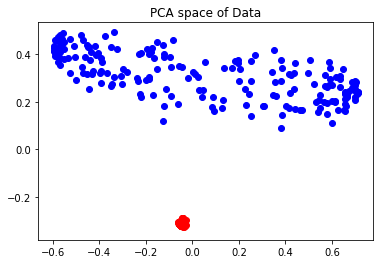

In [4]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn import datasets

n_samples=400
np.random.seed(0)
dataset = 'circles'
if dataset is 'blobs':
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=4)
elif dataset is 'circles':
    X, y = datasets.make_circles(n_samples=n_samples, factor=.3, noise=.05)
elif dataset is 'moons':
    X, y = datasets.make_moons(n_samples=n_samples, noise=.05)

reds = y==0
blues = y==1 


# X = X - np.mean(X, axis=0) 

pca = PCA(n_components=1)
pca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=True, gamma=10)
X_pca = pca.fit_transform(X)
X_back = pca.inverse_transform(X_pca)

# plt.scatter(X[:, 0], X[:, 1], color='b', label='Original data')
plt.figure()
plt.title("Original Data")
plt.scatter(X[reds, 0], X[reds, 1], color='r');
plt.scatter(X[blues, 0], X[blues, 1], color='b');


plt.figure()
plt.title("PCA space of Data")
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], color='r');
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], color='b');

# plt.figure()
# plt.scatter(X_back[reds, 0], X_back[reds, 1], color='r');
# plt.scatter(X_back[blues, 0], X_back[blues, 1], color='b');
# # 


# Dimensionality reduction: PCA  vs LDA

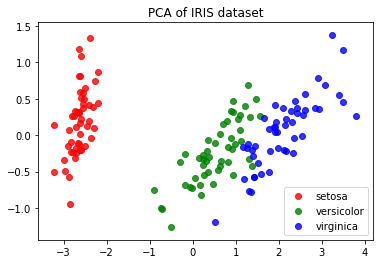

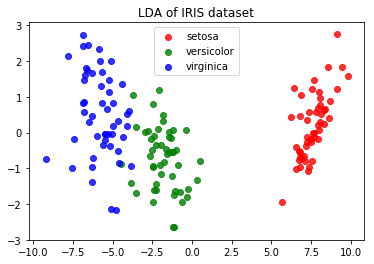

In [5]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X, y).transform(X)


plt.figure()
colors = ['r', 'g', 'b']

for i, target_name in enumerate(target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=colors[i], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for i, target_name in enumerate(target_names):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], color=colors[i], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset'); 

# Autoencoders

In [6]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


Using TensorFlow backend.


(60000, 784)
(10000, 784)


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 145us/step - loss: 0.3501 - val_loss: 0.2710
Epoch 2/40
60000/60000 [==============================] - 9s 150us/step - loss: 0.2638 - val_loss: 0.2529
Epoch 3/40
60000/60000 [==============================] - 7s 116us/step - loss: 0.2428 - val_loss: 0.2307
Epoch 4/40
60000/60000 [==============================] - 10s 168us/step - loss: 0.2234 - val_loss: 0.2137
Epoch 5/40
60000/60000 [==============================] - 8s 125us/step - loss: 0.2090 - val_loss: 0.2016
Epoch 6/40
60000/60000 [==============================] - 8s 133us/step - loss: 0.1981 - val_loss: 0.1916
Epoch 7/40
60000/60000 [==============================] - 10s 165us/step - loss: 0.1891 - val_loss: 0.1836
Epoch 8/40
60000/60000 [==============================] - 15s 243us/step - loss: 0.1818 - val_loss: 0.1770
Epoch 9/40
60000/60000 [==============================] - 13s 221us/step - loss: 0.1757 - val_loss:

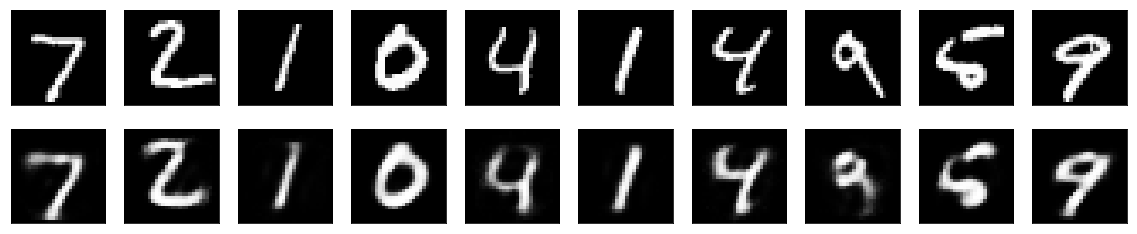

In [7]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
epochs = 40 
batch_size = 256 
# reg_param = 1e-4


# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=epochs ,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=1)


# # this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# # create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# # retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# # create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input), name='decoder')

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

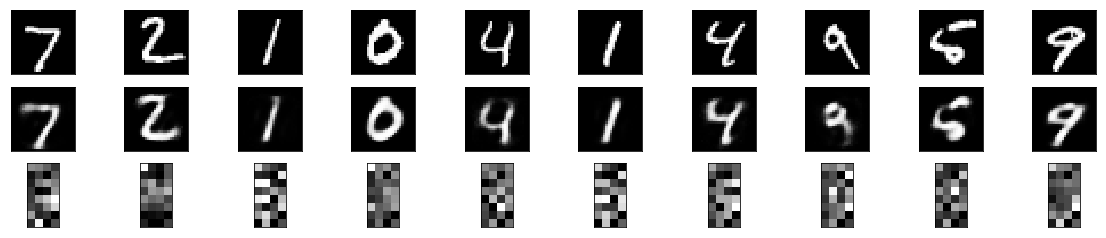

In [8]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display code
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs[i].reshape(-1, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [9]:
## Denoising

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

np.random.shuffle(x_train_noisy)
np.random.shuffle(x_test_noisy)

autoencoder.fit(x_train_noisy, x_train_noisy,
                epochs=epochs ,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_noisy),
                verbose=1)

encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display code
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs[i].reshape(-1, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.6022 - val_loss: 0.5464
Epoch 2/40
60000/60000 [==============================] - 3s 54us/step - loss: 0.5386 - val_loss: 0.5330
Epoch 3/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.5303 - val_loss: 0.5277
Epoch 4/40
60000/60000 [==============================] - 3s 55us/step - loss: 0.5263 - val_loss: 0.5247
Epoch 5/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.5239 - val_loss: 0.5228
Epoch 6/40
60000/60000 [==============================] - 3s 52us/step - loss: 0.5224 - val_loss: 0.5216
Epoch 7/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.5213 - val_loss: 0.5206
Epoch 8/40
60000/60000 [==============================] - 3s 51us/step - loss: 0.5204 - val_loss: 0.5199
Epoch 9/40
60000/60000 [==============================] - 5s 80us/step - loss: 0.5197 - val_loss: 0.5192
Epoch